In [2]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from keras import layers

2024-07-23 17:41:20.379408: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-23 17:41:20.690735: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-23 17:41:21.367540: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
#Coletando dados

df = pd.read_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/RJ_Reconstrucao_Crustaceos_2024_06_25.xlsx')

df_TOTAL_CRUSTACEOS_M_e_desagregar = pd.DataFrame(df[['Ano','Lagosta_art','Lagosta_ind','Lagosta_art_ind','Siri_azul_art','Siri_azul_ind','Siri_azul_art_ind','Caran_uca_art']])

#Juntando valores de art e ind em art_ind(quando os 2 estão presentes) 
   #Lagosta
for i in range(len(df_TOTAL_CRUSTACEOS_M_e_desagregar['Ano'])):
  if pd.isnull(df_TOTAL_CRUSTACEOS_M_e_desagregar.iloc[i,3])==True and pd.isnull(df_TOTAL_CRUSTACEOS_M_e_desagregar.iloc[i,2])==False and pd.isnull(df_TOTAL_CRUSTACEOS_M_e_desagregar.iloc[i,1])==False:
    df_TOTAL_CRUSTACEOS_M_e_desagregar.iloc[i,3] = df_TOTAL_CRUSTACEOS_M_e_desagregar.iloc[i,2] + df_TOTAL_CRUSTACEOS_M_e_desagregar.iloc[i,1] 
   #Siri_azul
for i in range(len(df_TOTAL_CRUSTACEOS_M_e_desagregar['Ano'])):
  if pd.isnull(df_TOTAL_CRUSTACEOS_M_e_desagregar.iloc[i,6])==True and pd.isnull(df_TOTAL_CRUSTACEOS_M_e_desagregar.iloc[i,5])==False and pd.isnull(df_TOTAL_CRUSTACEOS_M_e_desagregar.iloc[i,4])==False:
    df_TOTAL_CRUSTACEOS_M_e_desagregar.iloc[i,6] = df_TOTAL_CRUSTACEOS_M_e_desagregar.iloc[i,5] + df_TOTAL_CRUSTACEOS_M_e_desagregar.iloc[i,4] 

df_TOTAL_CRUSTACEOS_M_e_desagregar = df_TOTAL_CRUSTACEOS_M_e_desagregar[['Ano','Lagosta_art_ind','Siri_azul_art_ind','Caran_uca_art']].dropna().reset_index(drop=True)

dados = df_TOTAL_CRUSTACEOS_M_e_desagregar[['Ano','Lagosta_art_ind']]
for i in range(len(dados['Ano'])):
  dados.loc[i,'Soma'] = df_TOTAL_CRUSTACEOS_M_e_desagregar.loc[i, 'Lagosta_art_ind']+df_TOTAL_CRUSTACEOS_M_e_desagregar.loc[i, 'Siri_azul_art_ind']+df_TOTAL_CRUSTACEOS_M_e_desagregar.loc[i, 'Caran_uca_art']

#Fazendo as proporções
for i in range(len(dados['Ano'])):
  dados.loc[i,'Prop_Lagosta_art_ind'] = dados.loc[i,'Lagosta_art_ind'] / dados.loc[i,'Soma']


anos_com_dados = dados["Ano"].values
anos_para_prever = np.array([1955,1956,1957,1958,1959,1960,1961,1965,1974])
todos_anos = np.concatenate((anos_para_prever, anos_com_dados))
todos_anos.sort()



prop = dados['Prop_Lagosta_art_ind'].values

dados.head()

/tmp/ipykernel_4123/1864291273.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados.loc[i,'Soma'] = df_TOTAL_CRUSTACEOS_M_e_desagregar.loc[i, 'Lagosta_art_ind']+df_TOTAL_CRUSTACEOS_M_e_desagregar.loc[i, 'Siri_azul_art_ind']+df_TOTAL_CRUSTACEOS_M_e_desagregar.loc[i, 'Caran_uca_art']


,Ano,Lagosta_art_ind,Soma,Prop_Lagosta_art_ind
0,1962,8.0,257.0,0.031128
1,1963,34.0,458.0,0.074236
2,1964,13.0,302.0,0.043046
3,1966,16.0,214.0,0.074766
4,1967,71.0,342.0,0.207602


In [4]:
#Normalização dos dados

ano_mean = np.mean(anos_com_dados)
ano_std = np.std(anos_com_dados)
anos_para_prever_norm = (anos_para_prever - ano_mean)/ano_std
anos_com_dados_norm = (anos_com_dados - ano_mean)/ano_std

prop_mean = np.mean(prop)
prop_std = np.std(prop)
prop_norm = (prop - prop_mean)/prop_std

In [5]:
#Fit do modelo e salvando seus pesos
model = keras.Sequential([layers.Dense(96,activation='leaky_relu',input_shape=(1,)),
                             layers.Dense(32,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(96,activation='leaky_relu'),
                             layers.Dense(112,activation='leaky_relu'),
                             layers.Dense(1,activation='linear')])

opt = keras.optimizers.Nadam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')


#history = model.fit(anos_com_dados_norm,prop_norm, epochs=500, verbose=1)
#model.save_weights('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Lagosta/pesos prop Lagosta_art_ind/.weights.h5', overwrite=True)

/home/andre/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
model.load_weights('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Lagosta/pesos prop Lagosta_art_ind/.weights.h5')

/home/andre/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 31 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Previsões dos dados ausentes: [[0.        ]
 [0.        ]
 [0.00609151]
 [0.01385459]
 [0.02164862]
 [0.02907779]
 [0.03609893]
 [0.06475873]
 [0.28850955]]


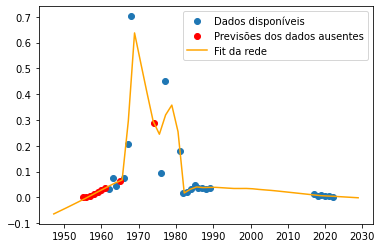

In [7]:
#Previsões
prev_disponiveis = model.predict(anos_com_dados_norm)*prop_std + prop_mean
prev_ausentes = model.predict(anos_para_prever_norm)*prop_std + prop_mean

#Colocando valores negativos para 0
for i in range(len(prev_ausentes)):
    if prev_ausentes[i]<0:
        prev_ausentes[i]=0
    if prev_ausentes[i]>=1:
        prev_ausentes[i]=1

#Plot dos dados e previsões
f1=plt.figure(1).add_subplot()
f1.scatter(anos_com_dados,prop,label='Dados disponíveis')
f1.scatter(anos_para_prever,prev_ausentes, color='red', label='Previsões dos dados ausentes')

#Plot do fit da rede
p = np.linspace(-2,2,50)
y = model.predict(p)*prop_std + prop_mean
f1.plot(p*ano_std + ano_mean,y,color='orange',label='Fit da rede')

#Print das previsões
print('Previsões dos dados ausentes:', prev_ausentes)


plt.legend()
plt.show()

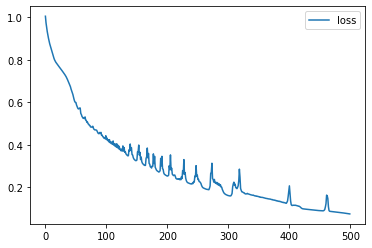

In [34]:
loss = history.history['loss']
plt.plot(loss,label='loss')
plt.legend()
plt.show()

In [8]:
#Lista de anos sem buracos normalizada e sua predição      (para poder me referir por indices)

anos = np.arange(1950,np.max(anos_para_prever)+1)
anos_norm = (anos-ano_mean)/ano_std
prev_continua = model.predict(anos_norm)*prop_std + prop_mean

for i in range(len(prev_continua)):
    if prev_continua[i]<0:
        prev_continua[i]=0
    if prev_continua[i]>=1:
        prev_continua[i]=1

#Trazendo valores previstos para TOTAL_CRUSTACEOS_M (sem Camarao_art_ind)
df_prev_M = pd.read_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Camarao misturado/Previsão TOTAL_CRUSTACEOS_M_sem_Camarao.xlsx')
df_prev_M = df_prev_M.replace(0,np.nan)

for i in range(len(df_prev_M['Ano'])):
       df.loc[i,'TOTAL_CRUSTACEOS_M'] = df_prev_M.loc[i,'TOTAL_CRUSTACEOS_M']


df_preenchido = df[['Ano','Lagosta_art_ind']]
for i in range(len(prev_continua)):
    if pd.isnull(df.loc[i,'Lagosta_art_ind'])==True:
      df_preenchido.loc[i,'Lagosta_art_ind']=df.loc[i,'TOTAL_CRUSTACEOS_M']*prev_continua[i]

df_preenchido = df_preenchido.loc[:,:]
with pd.option_context('display.max_rows', None,):
    print(df_preenchido)


#Planilha com os dados preenchidos
df_preenchido.to_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Lagosta/Previsão Lagosta_art_ind_1950-1974.xlsx')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
     Ano  Lagosta_art_ind
0   1950         0.000000
1   1951         0.000000
2   1952         0.000000
3   1953         0.000000
4   1954         0.000000
5   1955         0.000000
6   1956         0.000000
7   1957         1.074621
8   1958         3.117588
9   1959         7.622746
10  1960         6.082322
11  1961         5.568604
12  1962         8.000000
13  1963        34.000000
14  1964        13.000000
15  1965        19.242243
16  1966        16.000000
17  1967        71.000000
18  1968       441.000000
19  1969        40.560211
20  1970              NaN
21  1971              NaN
22  1972              NaN
23  1973              NaN
24  1974              NaN
25  1975              NaN
26  1976        26.000000
27  1977       506.000000
28  1978              NaN
29  1979              NaN
30  1980              NaN
31  1981              NaN
32  1982              NaN
33  1983              NaN
34  1984              NaN
35  1985              NaN


In [10]:
#TOTAL_CRUSTACEOS_M sem o que já foi para Camarao_art_ind, Lagosta_art_ind
TOTAL_CRUSTACEOS_M_sem_Cam_Lag = df[['Ano','TOTAL_CRUSTACEOS_M']]
for i in range(len(prev_continua)):
    TOTAL_CRUSTACEOS_M_sem_Cam_Lag.loc[i,'TOTAL_CRUSTACEOS_M'] -= df.loc[i,'TOTAL_CRUSTACEOS_M']*prev_continua[i]

with pd.option_context('display.max_rows', None,):
   print(TOTAL_CRUSTACEOS_M_sem_Cam_Lag)

TOTAL_CRUSTACEOS_M_sem_Cam_Lag.to_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Lagosta/Previsão TOTAL_CRUSTACEOS_M_sem_Cam_Lag.xlsx')


     Ano  TOTAL_CRUSTACEOS_M
0   1950          407.847412
1   1951          381.657593
2   1952          355.114258
3   1953          312.997803
4   1954          276.980713
5   1955          328.813477
6   1956          239.487793
7   1957          175.338165
8   1958          221.904510
9   1959          344.489563
10  1960          203.091812
11  1961          148.691711
12  1962          292.559296
13  1963          318.680481
14  1964          299.537720
15  1965          277.895691
16  1966          222.395233
17  1967          227.174042
18  1968          101.196701
19  1969           23.876068
20  1970                 NaN
21  1971                 NaN
22  1972                 NaN
23  1973                 NaN
24  1974                 NaN
25  1975         8185.000000
26  1976         3543.000000
27  1977         9064.000000
28  1978        24835.000000
29  1979        21827.000000
30  1980         3519.000000
31  1981         3190.500000
32  1982         3704.000000
33  1983      